## Data Mapping

In order to build a CNN model to predict the drought conditions across time and space, I'll need to set up a rectangular grid in order to map the drought conditions to pixels on the map. In this notebook, I use the shape file for the US climate divisions along with geopandas in order to assign climate divisions to each point on the grid. Every point that is contained inside the polygon of a given climate zone is assigned that climate zone. If a point is not contained in any of the climate zones, it is assigned a zero.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysal as ps
import geopandas as gpd

%matplotlib inline

/anaconda3/envs/geopandas/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
drt = pd.read_csv("./data/drought_data_combined.csv")

The shapefile for the US climate divisions map was downloaded from [NOAA.](https://www.esrl.noaa.gov/psd/data/usclimdivs/boundaries.html)

In [3]:
shp_link = "./data/CONUS_CLIMATE_DIVISIONS.shp/GIS.OFFICIAL_CLIM_DIVISIONS.shp"

In [4]:
us_climate_map = ps.open(shp_link)

In [5]:
us_climate_map.header

{'File Code': 9994,
 'Unused0': 0,
 'Unused1': 0,
 'Unused2': 0,
 'Unused3': 0,
 'Unused4': 0,
 'File Length': 25371266,
 'Version': 1000,
 'Shape Type': 5,
 'BBOX Xmin': -124.73317395041693,
 'BBOX Ymin': 24.54394000612723,
 'BBOX Xmax': -66.95000489600847,
 'BBOX Ymax': 49.38435902904689,
 'BBOX Zmin': 0.0,
 'BBOX Zmax': 0.0,
 'BBOX Mmin': 0.0,
 'BBOX Mmax': 0.0}

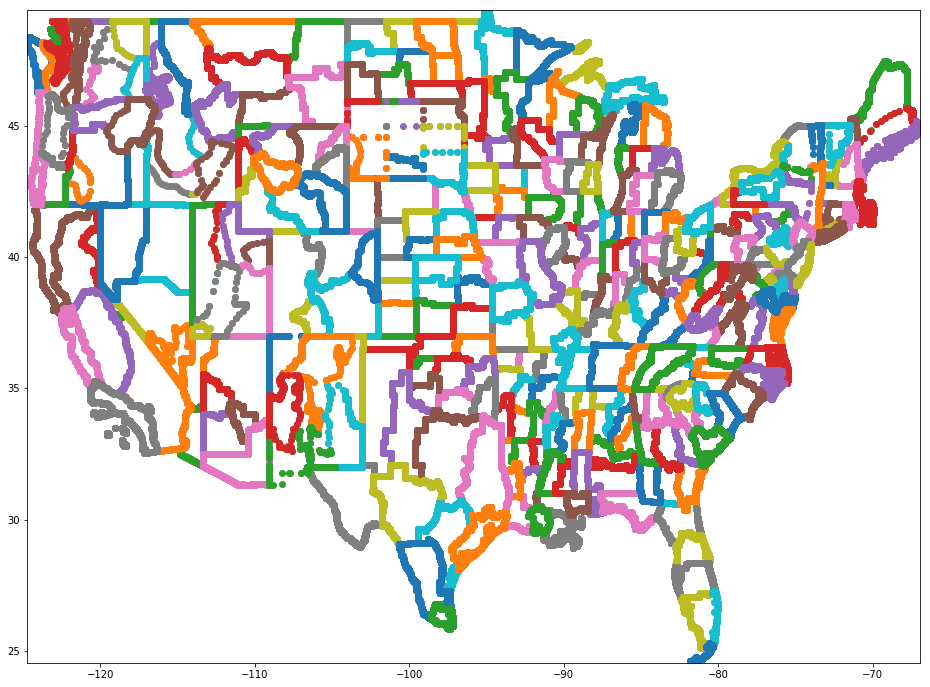

In [6]:
# This code was adapted from the DSI Spatial Data Analysis lesson. 
# The original code was credited to Tucker Allen (DSI-3 graduate).

plt.figure(figsize=(16, 12))
for i in range(len(list(us_climate_map))):
    x = []
    y = []
    for j in us_climate_map[i].vertices: 
        x.append(j[0])
        y.append(j[1])
    plt.scatter(x, y)
    plt.xlim(us_climate_map.header['BBOX Xmin'] , us_climate_map.header['BBOX Xmax'])
    plt.ylim(us_climate_map.header['BBOX Ymin'] , us_climate_map.header['BBOX Ymax'])

In [7]:
df_map = gpd.read_file(shp_link)

df_map.head()

,OBJECTID,STATE,STATE_FIPS,CD_2DIG,STATE_CODE,CLIMDIV,CD_NEW,FIPS_CD,NCDC_GEO_I,NAME,ST_ABBRV,SHAPE_AREA,SHAPE_LEN,geometry
0,91,New Mexico,35,05,29,2905,5,3505,1.0,CENTRAL VALLEY,NM,0.0,0.0,POLYGON ((-105.8779980003069 33.24399899955506...
1,92,New Mexico,35,06,29,2906,6,3506,2.0,CENTRAL HIGHLANDS,NM,0.0,0.0,POLYGON ((-105.1490020000417 32.63999899975494...
2,93,Idaho,16,01,10,1001,1,1601,3.0,PANHANDLE,ID,0.0,0.0,POLYGON ((-116.0488219420784 47.97672702793091...
3,94,Idaho,16,02,10,1002,2,1602,4.0,NORTH CENTRAL PRAIRIES,ID,0.0,0.0,POLYGON ((-116.1569979996574 45.71799899955511...
4,96,Idaho,16,04,10,1004,4,1604,6.0,CENTRAL MOUNTAINS,ID,0.0,0.0,POLYGON ((-113.8346479403496 45.52065202607105...


In [8]:
from shapely.geometry import Point, Polygon

In [9]:
latitudes = [0.25*i for i in list(range(96, 201))]
latitudes.reverse()

longitudes = [0.25*i for i in list(range(-500, -263))]

In [10]:
len(latitudes)

105

In [11]:
len(longitudes)

237

In [12]:
def grid_build(latitudes, longitudes):
    clim_div_grid = []
    for lat in latitudes:
        clim_div_row = []
        for long in longitudes:
            p = Point(long, lat)
            clim_div = 0
            for polygon in df_map["geometry"]:
                if p.within(polygon):
                    clim_div = df_map[df_map["geometry"] == polygon]["CLIMDIV"].values[0]
                    break
            clim_div_row.append(clim_div)

        clim_div_grid.append(clim_div_row)
        if len(clim_div_grid) % 10 == 0:
            print(f"{len(clim_div_grid)} rows generated")
        elif len(clim_div_grid) == len(latitudes):
            print("COMPLETE")
        
    return clim_div_grid

In [13]:
us_clim_div_grid = grid_build(latitudes, longitudes)

10 rows generated
20 rows generated
30 rows generated
40 rows generated
50 rows generated
60 rows generated
70 rows generated
80 rows generated
90 rows generated
100 rows generated
COMPLETE


In [14]:
us_clim_div_grid = pd.DataFrame(us_clim_div_grid, columns = longitudes, index = latitudes)

In [15]:
us_clim_div_grid.head()

,-125.0,-124.75,-124.5,-124.25,-124.0,-123.75,-123.5,-123.25,-123.0,-122.75,...,-68.25,-68.0,-67.75,-67.5,-67.25,-67.0,-66.75,-66.5,-66.25,-66.0
50.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49.75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49.50,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49.25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49.00,0,0,0,0,0,0,0,0,0,4503,...,0,0,0,0,0,0,0,0,0,0


In [16]:
us_clim_div_grid.to_csv("./data/us_climate_division_grid.csv")